## Capstone Project - Battle of the Neighborhoods
Filipino Restaurant Analysis in Los Angeles, California

## Data

<b>Based on the criteria to identify the best areas in LA for our audience, the following factors that will influence the final decision are:</b>

- Number of existing filipino restaurants/venues
- Number of and distance to filipino restaurants/venues in the neighborhood 
- Distance of neighborhood to city's center


<b>The following data sources will be needed to extract/generate the required information: </b>
- GeoJSON of Los Angeles county data:
http://boundaries.latimes.com/sets/

- Number of filipino restaurants and their location in every neighbourhood — Foursquare API

 Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

/Users/parisring/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Matplotlib version:  3.2.1
Libraries imported


In [2]:
import json

In [3]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install rtree 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import geopandas as gpd
import rtree
from shapely.geometry import Point 
import re 
print("Installed!")

Installed!


In [16]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [17]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

<b> First, identifying our coordinates for Los Angeles</b>

In [18]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


<b> Next, let's pull in the JSON file for Los Angeles' neighborhoods and their given geometry by using Geopandas</b>

In [32]:
la = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v6.geojson')

#pull only neighborhood name and the given geometry. Renaming the field 'name' to 'Neighborhood'
la = la[['name', 'geometry']]
la.rename(columns={'name': 'Neighborhood'}, inplace=True)


la

Neighborhood                                           geometry
0              Acton  MULTIPOLYGON (((-118.20703 34.53902, -118.1894...
1    Adams-Normandie  MULTIPOLYGON (((-118.30800 34.03740, -118.3006...
2       Agoura Hills  MULTIPOLYGON (((-118.77621 34.16816, -118.7263...
3         Agua Dulce  MULTIPOLYGON (((-118.37822 34.48811, -118.3783...
4           Alhambra  MULTIPOLYGON (((-118.12175 34.10504, -118.1168...
..               ...                                                ...
313       Wilmington  MULTIPOLYGON (((-118.22476 33.82461, -118.2245...
314   Windsor Square  MULTIPOLYGON (((-118.31359 34.07623, -118.3135...
315         Winnetka  MULTIPOLYGON (((-118.56231 34.23199, -118.5622...
316   Woodland Hills  MULTIPOLYGON (((-118.57644 34.18836, -118.5748...
317      Yorba Linda  MULTIPOLYGON (((-117.83449 33.87991, -117.8396...

[318 rows x 2 columns]

<b>Now let's visualize the data from the GeoJSON to view the different neighborhoods in Los Angeles using Folium</b>

In [51]:
maploc = folium.Map(location=[latitude,longitude],zoom_start=10,tiles="OpenStreetMap")

folium.GeoJson(la).add_to(maploc)
maploc

<b> We will start pulling the Filipino Restaurant venue data from the FourSquare API</b>

In [27]:
CLIENT_ID = 'ZEN5NXXEEMSND55V4OGNWWRUUKATAWXAGWYQANPUYVR00VTU' # your Foursquare ID
CLIENT_SECRET = 'C4GOPGPY5DU0XEGVSKCNERQBPVLUQ1L1THGOI3GTZJA5H4JD' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version
LIMIT = 1000
radius = 10000000

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: ZEN5NXXEEMSND55V4OGNWWRUUKATAWXAGWYQANPUYVR00VTU
CLIENT_SECRET:C4GOPGPY5DU0XEGVSKCNERQBPVLUQ1L1THGOI3GTZJA5H4JD


In [28]:
#Searching for venues
search_query = 'Filipino'
radius = 10000000
print(search_query + ' .... OK!')

Filipino .... OK!


In [30]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=ZEN5NXXEEMSND55V4OGNWWRUUKATAWXAGWYQANPUYVR00VTU&client_secret=C4GOPGPY5DU0XEGVSKCNERQBPVLUQ1L1THGOI3GTZJA5H4JD&ll=34.0536909,-118.2427666&v=20200601&query=Filipino&radius=10000000&limit=1000'

In [31]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eef803377af03001b28bd50'},
 'response': {'venues': [{'id': '4e0f572a62843e04afb486ca',
    'name': 'Filipino American Community of Los Angeles',
    'location': {'lat': 34.06891,
     'lng': -118.26436,
     'labeledLatLngs': [{'label': 'display',
       'lat': 34.06891,
       'lng': -118.26436}],
     'distance': 2614,
     'cc': 'US',
     'city': 'Los Angeles',
     'state': 'CA',
     'country': 'United States',
     'formattedAddress': ['Los Angeles, CA', 'United States']},
    'categories': [],
    'referralId': 'v-1592754169',
    'hasPerk': False},
   {'id': '504be490e4b05828d13e2b81',
    'name': 'Gintong Kasaysayan, Gintong Pamana Filipino Mural',
    'location': {'lat': 34.06375949218111,
     'lng': -118.26481061679617,
     'labeledLatLngs': [{'label': 'display',
       'lat': 34.06375949218111,
       'lng': -118.26481061679617}],
     'distance': 2321,
     'postalCode': '90026',
     'cc': 'US',
     'city': 'Los Angeles',
     'st

In [33]:
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/Users/parisring/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


id  \
0  4e0f572a62843e04afb486ca   
1  504be490e4b05828d13e2b81   
2  4b905138f964a520b38333e3   
3  4bae6a44f964a52062af3be3   
4  568380b5498e3e34d08d0d80   

                                                name  \
0         Filipino American Community of Los Angeles   
1  Gintong Kasaysayan, Gintong Pamana Filipino Mural   
2                              Historic Filipinotown   
3      Central Filipino Seventh-Day Adventist Church   
4                       LA Rsin BBQ Truck (Filipino)   

                                          categories    referralId  hasPerk  \
0                                                 []  v-1592754169    False   
1  [{'id': '4deefb944765f83613cdba6e', 'name': 'H...  v-1592754169    False   
2  [{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...  v-1592754169    False   
3  [{'id': '4bf58dd8d48988d132941735', 'name': 'C...  v-1592754169    False   
4  [{'id': '4bf58dd8d48988d1cb941735', 'name': 'F...  v-1592754169    False   

   location.lat  location.lng  \
0     34.068910   -118.264360   
1     34.063759   -118.264811   
2     34.069926   -118.275408   
3     34.141106   -118.182614   
4     34.094411   -118.080310   

                             location.labeledLatLngs  location.distance  \
0  [{'label': 'display', 'lat': 34.06891, 'lng': ...               2614   
1  [{'label': 'display', 'lat': 34.06375949218111...               2321   
2  [{'label': 'display', 'lat': 34.06992551754767...               3511   
3  [{'label': 'display', 'lat': 34.14110597726068...              11199   
4  [{'label': 'display', 'lat': 34.09441054623067...              15650   

  location.cc  ...                          location.formattedAddress  \
0          US  ...                   [Los Angeles, CA, United States]   
1          US  ...             [Los Angeles, CA 90026, United States]   
2          US  ...             [Los Angeles, CA 90026, United States]   
3          US  ...  [777 Colorado Blvd (btwn Figueroa & San Rafael...   
4          US  ...  [Venice Boulevard (S. La Cienega Boulevard), L...   

  location.postalCode   location.address        location.crossStreet  \
0                 NaN                NaN                         NaN   
1               90026                NaN                         NaN   
2               90026                NaN                         NaN   
3               90041  777 Colorado Blvd  btwn Figueroa & San Rafael   
4                 NaN   Venice Boulevard     S. La Cienega Boulevard   

  delivery.id delivery.url delivery.provider.name  \
0         NaN          NaN                    NaN   
1         NaN          NaN                    NaN   
2         NaN          NaN                    NaN   
3         NaN          NaN                    NaN   
4         NaN          NaN                    NaN   

  delivery.provider.icon.prefix delivery.provider.icon.sizes  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   

  delivery.provider.icon.name  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  

[5 rows x 23 columns]

In [61]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered = pd.DataFrame(dataframe_filtered)

#Remove those that are not related to filipino restaurants/eateries, and any unlabeled categories

dataframe_filtered = dataframe_filtered[~dataframe_filtered.categories.isin(["Church", "Martial Arts Dojo", "Car Wash", "Historic Site", "School", "Non-Profit", "Neighborhood"])]
dataframe_filtered = dataframe_filtered[dataframe_filtered['categories'].notna()]
dataframe_filtered

name             categories  \
4                   LA Rsin BBQ Truck (Filipino)             Food Truck   
6                                Filipino Fusion    Fried Chicken Joint   
7   Filipino Bagnet Glendale Restaurant & Bakery                 Bakery   
8                Pinoy Pinay Filipino Restaurant    Filipino Restaurant   
9               Bicol Express Filipino Fast Food    Filipino Restaurant   
11   Eat.Play.Move. Filipino Angeleno Food Event    Outdoor Event Space   
12         International Express Filipino Market    Filipino Restaurant   
15                            White Rabbit Truck             Food Truck   
17                  Madam Camaes Filipino Palace  General Entertainment   
20                 Filipino Bistro Asian Cuisine    Filipino Restaurant   
21                      Lance's Filipino Cuisine    Filipino Restaurant   
27                         Chaaste Family Market          Grocery Store   
29               Original Lapid Filipino Cuisine    Filipino Restaurant   
30                              Filipino Express       Asian Restaurant   
31               Lucky 8 Chinese & Filipino Food     Chinese Restaurant   
32           Handugan Authentic Filipino Cuisine    Filipino Restaurant   
34              Aling Gloria's (Filipino Buffet)    Filipino Restaurant   
35                  Filipino Mini Mart And Video     Miscellaneous Shop   
37                                Hapag Filipino    Filipino Restaurant   
38                         Bahay Kainan Filipino                   Food   
40                              Cuizina Filipino             Restaurant   
41                           Johnny's Filipino's    Filipino Restaurant   
42            Herbie's Cuisine - Filipino Fiesta    Filipino Restaurant   
43                      Miguels Filipino Mexican   Fast Food Restaurant   
45    Rolling Pin Bakehouse and Filipinocatessen                 Bakery   
47                         Sawali Grill Filipino                   Food   
48                           Tambuli Supermarket          Grocery Store   
49                   Bingo's Filipino Restaurant       Asian Restaurant   

          lat         lng                                     labeledLatLngs  \
4   34.094411 -118.080310  [{'label': 'display', 'lat': 34.09441054623067...   
6   34.131548 -118.245591  [{'label': 'display', 'lat': 34.13154799999999...   
7   34.142457 -118.232501  [{'label': 'display', 'lat': 34.1424566, 'lng'...   
8   33.857718 -118.080331  [{'label': 'display', 'lat': 33.85771754506848...   
9   34.131464 -118.257401  [{'label': 'display', 'lat': 34.131464, 'lng':...   
11  34.141122 -118.223252  [{'label': 'display', 'lat': 34.141122, 'lng':...   
12  33.789787 -118.325729  [{'label': 'display', 'lat': 33.78978729248047...   
15  34.073639 -118.231878  [{'label': 'display', 'lat': 34.07363875693362...   
17  34.038029 -118.391256  [{'label': 'display', 'lat': 34.03802857333641...   
20  33.865963 -118.092931  [{'label': 'display', 'lat': 33.865963, 'lng':...   
21  33.916229 -118.326950  [{'label': 'display', 'lat': 33.91622924804687...   
27  34.151447 -118.112835  [{'label': 'display', 'lat': 34.15144681681926...   
29  33.873290 -118.114784  [{'label': 'display', 'lat': 33.87329, 'lng': ...   
30  33.882540 -117.997873  [{'label': 'display', 'lat': 33.88254049656022...   
31  33.834272 -118.241050  [{'label': 'display', 'lat': 33.83427215391716...   
32  33.832055 -118.285805  [{'label': 'display', 'lat': 33.83205492110295...   
34  33.872765 -118.071388  [{'label': 'display', 'lat': 33.87276458740234...   
35  33.816602 -117.993927  [{'label': 'display', 'lat': 33.816602, 'lng':...   
37  33.825247 -118.276001  [{'label': 'display', 'lat': 33.82524742833059...   
38  33.804107 -118.218424  [{'label': 'display', 'lat': 33.804107, 'lng':...   
40  33.803241 -118.215744  [{'label': 'display', 'lat': 33.803241, 'lng':...   
41  33.902199 -118.117653  [{'label': 'display', 'lat': 33.902199, 'lng':...   
42  34.106084 -117.898373  [

In [62]:
#Names of All Venues
dataframe_filtered.name

4                     LA Rsin BBQ Truck (Filipino)
6                                  Filipino Fusion
7     Filipino Bagnet Glendale Restaurant & Bakery
8                  Pinoy Pinay Filipino Restaurant
9                 Bicol Express Filipino Fast Food
11     Eat.Play.Move. Filipino Angeleno Food Event
12           International Express Filipino Market
15                              White Rabbit Truck
17                    Madam Camaes Filipino Palace
20                   Filipino Bistro Asian Cuisine
21                        Lance's Filipino Cuisine
27                           Chaaste Family Market
29                 Original Lapid Filipino Cuisine
30                                Filipino Express
31                 Lucky 8 Chinese & Filipino Food
32             Handugan Authentic Filipino Cuisine
34                Aling Gloria's (Filipino Buffet)
35                    Filipino Mini Mart And Video
37                                  Hapag Filipino
38                           Ba

In [63]:
df_filt_display = dataframe_filtered[['name', 'categories', 'lat', 'lng']]
df_filt_display.head()

name           categories  \
4                  LA Rsin BBQ Truck (Filipino)           Food Truck   
6                               Filipino Fusion  Fried Chicken Joint   
7  Filipino Bagnet Glendale Restaurant & Bakery               Bakery   
8               Pinoy Pinay Filipino Restaurant  Filipino Restaurant   
9              Bicol Express Filipino Fast Food  Filipino Restaurant   

         lat         lng  
4  34.094411 -118.080310  
6  34.131548 -118.245591  
7  34.142457 -118.232501  
8  33.857718 -118.080331  
9  34.131464 -118.257401

In [69]:
print("There are", dataframe_filtered.shape[0], "venues")

There are 28 venues


<b> Now since we have the Filipino venues that will be used in our analysis, let's visualize the venues on the map we created earlier.</b>

In [64]:
la_venues_map = folium.Map(location=[latitude,longitude],zoom_start=10)

folium.GeoJson(la).add_to(la_venues_map)

# generate map for LA and the Filipino venues/restaurants

# add the Filipino venues/restauranats as red circle markers -- with the popup labels as the name of the venue 
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(la_venues_map)
    
# display map
la_venues_map

## With the package, GeoPandas, let's join the two datasets together (venue data and Los Angeles data, to find the venues and their assocated neighborhoods, using an sjoin. 

In [82]:
geom = dataframe_filtered.apply(lambda x : Point([x["lng"],x["lat"]]), axis=1)

df_filtered= gpd.GeoDataFrame(dataframe_filtered, geometry=geom) #geom is a Series
df_filtered.crs = {"init" :"epsg:4326"}
la.crs = {"init" :"epsg:4326"}
print(df_filtered.head())

                                           name           categories  \
4                  LA Rsin BBQ Truck (Filipino)           Food Truck   
6                               Filipino Fusion  Fried Chicken Joint   
7  Filipino Bagnet Glendale Restaurant & Bakery               Bakery   
8               Pinoy Pinay Filipino Restaurant  Filipino Restaurant   
9              Bicol Express Filipino Fast Food  Filipino Restaurant   

         lat         lng                                     labeledLatLngs  \
4  34.094411 -118.080310  [{'label': 'display', 'lat': 34.09441054623067...   
6  34.131548 -118.245591  [{'label': 'display', 'lat': 34.13154799999999...   
7  34.142457 -118.232501  [{'label': 'display', 'lat': 34.1424566, 'lng'...   
8  33.857718 -118.080331  [{'label': 'display', 'lat': 33.85771754506848...   
9  34.131464 -118.257401  [{'label': 'display', 'lat': 34.131464, 'lng':...   

   distance  cc         city state        country  \
4     15650  US  Los Angeles    CA  Uni

/Users/parisring/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [86]:
la_join = gpd.sjoin(df_filtered, la, op="within")
la_join

name             categories  \
4                   LA Rsin BBQ Truck (Filipino)             Food Truck   
6                                Filipino Fusion    Fried Chicken Joint   
7   Filipino Bagnet Glendale Restaurant & Bakery                 Bakery   
9               Bicol Express Filipino Fast Food    Filipino Restaurant   
8                Pinoy Pinay Filipino Restaurant    Filipino Restaurant   
20                 Filipino Bistro Asian Cuisine    Filipino Restaurant   
11   Eat.Play.Move. Filipino Angeleno Food Event    Outdoor Event Space   
12         International Express Filipino Market    Filipino Restaurant   
15                            White Rabbit Truck             Food Truck   
17                  Madam Camaes Filipino Palace  General Entertainment   
21                      Lance's Filipino Cuisine    Filipino Restaurant   
27                         Chaaste Family Market          Grocery Store   
29               Original Lapid Filipino Cuisine    Filipino Restaurant   
41                           Johnny's Filipino's    Filipino Restaurant   
30                              Filipino Express       Asian Restaurant   
31               Lucky 8 Chinese & Filipino Food     Chinese Restaurant   
32           Handugan Authentic Filipino Cuisine    Filipino Restaurant   
37                                Hapag Filipino    Filipino Restaurant   
45    Rolling Pin Bakehouse and Filipinocatessen                 Bakery   
34              Aling Gloria's (Filipino Buffet)    Filipino Restaurant   
35                  Filipino Mini Mart And Video     Miscellaneous Shop   
43                      Miguels Filipino Mexican   Fast Food Restaurant   
47                         Sawali Grill Filipino                   Food   
49                   Bingo's Filipino Restaurant       Asian Restaurant   
38                         Bahay Kainan Filipino                   Food   
40                              Cuizina Filipino             Restaurant   
48                           Tambuli Supermarket          Grocery Store   
42            Herbie's Cuisine - Filipino Fiesta    Filipino Restaurant   

          lat         lng                                     labeledLatLngs  \
4   34.094411 -118.080310  [{'label': 'display', 'lat': 34.09441054623067...   
6   34.131548 -118.245591  [{'label': 'display', 'lat': 34.13154799999999...   
7   34.142457 -118.232501  [{'label': 'display', 'lat': 34.1424566, 'lng'...   
9   34.131464 -118.257401  [{'label': 'display', 'lat': 34.131464, 'lng':...   
8   33.857718 -118.080331  [{'label': 'display', 'lat': 33.85771754506848...   
20  33.865963 -118.092931  [{'label': 'display', 'lat': 33.865963, 'lng':...   
11  34.141122 -118.223252  [{'label': 'display', 'lat': 34.141122, 'lng':...   
12  33.789787 -118.325729  [{'label': 'display', 'lat': 33.78978729248047...   
15  34.073639 -118.231878  [{'label': 'display', 'lat': 34.07363875693362...   
17  34.038029 -118.391256  [{'label': 'display', 'lat': 34.03802857333641...   
21  33.916229 -118.326950  [{'label': 'display', 'lat': 33.91622924804687...   
27  34.151447 -118.112835  [{'label': 'display', 'lat': 34.15144681681926...   
29  33.873290 -118.114784  [{'label': 'display', 'lat': 33.87329, 'lng': ...   
41  33.902199 -118.117653  [{'label': 'display', 'lat': 33.902199, 'lng':...   
30  33.882540 -117.997873  [{'label': 'display', 'lat': 33.88254049656022...   
31  33.834272 -118.241050  [{'label': 'display', 'lat': 33.83427215391716...   
32  33.832055 -118.285805  [{'label': 'display', 'lat': 33.83205492110295...   
37  33.825247 -118.276001  [{'label': 'display', 'lat': 33.82524742833059...   
45  33.830824 -118.278617  [{'label': 'display', 'lat': 33.830824, 'lng':...   
34  33.872765 -118.071388  [{'label': 'display', 'lat': 33.87276458740234...   
35  33.816602 -117.993927  [{'label': 'display', 'lat': 33.816602, 'lng':...   
43  33.831745 -117.999397  [{'label': 'entrance', 'lat': 33.831789, 'lng'...   
47  33.816747 -118.008887  [

## Analyze each neighborhood

In [87]:
# one hot encoding
la_onehot = pd.get_dummies(la_join[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_join['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.head()

Neighborhood  Asian Restaurant  Bakery  Chinese Restaurant  \
4  East San Gabriel                 0       0                   0   
6          Glendale                 0       0                   0   
7          Glendale                 0       1                   0   
9          Glendale                 0       0                   0   
8          Cerritos                 0       0                   0   

   Fast Food Restaurant  Filipino Restaurant  Food  Food Truck  \
4                     0                    0     0           1   
6                     0                    0     0           0   
7                     0                    0     0           0   
9                     0                    1     0           0   
8                     0                    1     0           0   

   Fried Chicken Joint  General Entertainment  Grocery Store  \
4                    0                      0              0   
6                    1                      0              0   
7                    0                      0              0   
9                    0                      0              0   
8                    0                      0              0   

   Miscellaneous Shop  Outdoor Event Space  Restaurant  
4                   0                    0           0  
6                   0                    0           0  
7                   0                    0           0  
9                   0                    0           0  
8                   0                    0           0

In [88]:
la_onehot.shape

(28, 14)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [93]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped

Neighborhood  Asian Restaurant    Bakery  Chinese Restaurant  \
0            Anaheim              0.25  0.000000                0.00   
1            Artesia              0.00  0.000000                0.00   
2         Bellflower              0.00  0.000000                0.00   
3        Beverlywood              0.00  0.000000                0.00   
4         Buena Park              1.00  0.000000                0.00   
5             Carson              0.00  0.250000                0.25   
6           Cerritos              0.00  0.000000                0.00   
7             Covina              0.00  0.000000                0.00   
8         Eagle Rock              0.00  0.000000                0.00   
9   East San Gabriel              0.00  0.000000                0.00   
10      Elysian Park              0.00  0.000000                0.00   
11          Glendale              0.00  0.333333                0.00   
12         Hawthorne              0.00  0.000000                0.00   
13            Lomita              0.00  0.000000                0.00   
14        Long Beach              0.00  0.000000                0.00   
15          Pasadena              0.00  0.000000                0.00   

    Fast Food Restaurant  Filipino Restaurant      Food  Food Truck  \
0                   0.25             0.000000  0.250000         0.0   
1                   0.00             1.000000  0.000000         0.0   
2                   0.00             1.000000  0.000000         0.0   
3                   0.00             0.000000  0.000000         0.0   
4                   0.00             0.000000  0.000000         0.0   
5                   0.00             0.500000  0.000000         0.0   
6                   0.00             1.000000  0.000000         0.0   
7                   0.00             1.000000  0.000000         0.0   
8                   0.00             0.000000  0.000000         0.0   
9                   0.00             0.000000  0.000000         1.0   
10                  0.00             0.000000  0.000000         1.0   
11                  0.00             0.333333  0.000000         0.0   
12                  0.00             1.000000  0.000000         0.0   
13                  0.00             1.000000  0.000000         0.0   
14                  0.00             0.000000  0.333333         0.0   
15                  0.00             0.000000  0.000000         0.0   

    Fried Chicken Joint  General Entertainment  Grocery Store  \
0              0.000000                    0.0       0.000000   
1              0.000000                    0.0       0.000000   
2              0.000000                    0.0       0.000000   
3              0.000000                    1.0       0.000000   
4              0.000000                    0.0       0.000000   
5              0.000000                    0.0       0.000000   
6              0.000000                    0.0       0.000000   
7              0.000000                    0.0       0.000000   
8              0.000000                    0.0       0.000000   
9              0.000000                    0.0       0.000000   
10             0.000000                    0.0       0.000000   
11             0.333333                    0.0       0.000000   
12             0.000000                    0.0       0.000000   
13             0.000000                    0.0       0.000000   
14             0.000000                    0.0       0.333333   
15             0.000000                    0.0       1.000000   

    Miscellaneous Shop  Outdoor Event Space  Restaurant  
0                 0.25                  0.0    0.000000  
1                 0.00                  0.0    0.000000  
2                 0.00                  0.0    0.000000  
3                 0.00                  0.0    0.000000  
4                 0.00                  0.0    0.000000  
5                 0.00                  0.0    0.000000  
6                 0.00                  0.0    0.000000  
7    

#### Let's confirm the new size

In [91]:
la_grouped.shape

(16, 14)

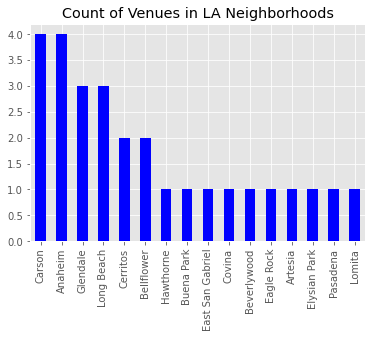

In [124]:
#Create a bar chart to show the count of venues within LA Neighborhoods that have a Filipino Restaurant/Venue
s = la_join['Neighborhood'].value_counts()
s.plot(kind='bar', color='blue', title='Count of Venues in LA Neighborhoods')

### Now, let's Cluster the Neighborhoods
#### Run k-means to cluster the neighborhood

In [115]:
# set number of clusters
kclusters = 5

la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 1, 0, 1, 2, 2, 3, 4], dtype=int32)

In [118]:
# add clustering labels
la_grouped.insert(0, 'Cluster Labels', kmeans.labels_)


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
la_merged = la_join.join(la_grouped.set_index('Neighborhood'), on='Neighborhood')

la_merged.head() # check the last columns!

name           categories  \
4                  LA Rsin BBQ Truck (Filipino)           Food Truck   
6                               Filipino Fusion  Fried Chicken Joint   
7  Filipino Bagnet Glendale Restaurant & Bakery               Bakery   
9              Bicol Express Filipino Fast Food  Filipino Restaurant   
8               Pinoy Pinay Filipino Restaurant  Filipino Restaurant   

         lat         lng                                     labeledLatLngs  \
4  34.094411 -118.080310  [{'label': 'display', 'lat': 34.09441054623067...   
6  34.131548 -118.245591  [{'label': 'display', 'lat': 34.13154799999999...   
7  34.142457 -118.232501  [{'label': 'display', 'lat': 34.1424566, 'lng'...   
9  34.131464 -118.257401  [{'label': 'display', 'lat': 34.131464, 'lng':...   
8  33.857718 -118.080331  [{'label': 'display', 'lat': 33.85771754506848...   

   distance  cc         city state        country  ... Fast Food Restaurant  \
4     15650  US  Los Angeles    CA  United States  ...                  0.0   
6      8670  US     Glendale    CA  United States  ...                  0.0   
7      9926  US     Glendale    CA  United States  ...                  0.0   
9      8762  US     Glendale    CA  United States  ...                  0.0   
8     26474  US     Cerritos    CA  United States  ...                  0.0   

  Filipino Restaurant Food Food Truck Fried Chicken Joint  \
4            0.000000  0.0        1.0            0.000000   
6            0.333333  0.0        0.0            0.333333   
7            0.333333  0.0        0.0            0.333333   
9            0.333333  0.0        0.0            0.333333   
8            1.000000  0.0        0.0            0.000000   

  General Entertainment  Grocery Store Miscellaneous Shop  \
4                   0.0            0.0                0.0   
6                   0.0            0.0                0.0   
7                   0.0            0.0                0.0   
9                   0.0            0.0                0.0   
8                   0.0            0.0                0.0   

   Outdoor Event Space  Restaurant  
4                  0.0         0.0  
6                  0.0         0.0  
7                  0.0         0.0  
9                  0.0         0.0  
8                  0.0         0.0  

[5 rows x 32 columns]

In [120]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['lat'], la_merged['lng'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b> Cluster 0</b>

In [133]:
la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

categories  distance  cc        city state        country  \
30  Asian Restaurant     29566  US  Buena Park    CA  United States   

                                     formattedAddress postalCode  \
30  [4544 Beach Blvd (at Stage Rd), Buena Park, CA...      90621   

            address  crossStreet  ... Fast Food Restaurant  \
30  4544 Beach Blvd  at Stage Rd  ...                  0.0   

   Filipino Restaurant  Food Food Truck  Fried Chicken Joint  \
30                 0.0   0.0        0.0                  0.0   

    General Entertainment  Grocery Store  Miscellaneous Shop  \
30                    0.0            0.0                 0.0   

    Outdoor Event Space  Restaurant  
30                  0.0         0.0  

[1 rows x 28 columns]

<b> Cluster 1</b>

In [134]:
la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

categories  distance  cc         city state        country  \
6     Fried Chicken Joint      8670  US     Glendale    CA  United States   
7                  Bakery      9926  US     Glendale    CA  United States   
9     Filipino Restaurant      8762  US     Glendale    CA  United States   
17  General Entertainment     13806  US  Los Angeles    CA  United States   
27          Grocery Store     16181  US     Pasadena    CA  United States   
31     Chinese Restaurant     24425  US       Carson    CA  United States   
32    Filipino Restaurant     24990  US       Carson    CA  United States   
37    Filipino Restaurant     25614  US       Carson    CA  United States   
45                 Bakery     25029  US       Carson    CA  United States   
35     Miscellaneous Shop     34996  US      Anaheim    CA  United States   
43   Fast Food Restaurant     33399  US      Anaheim    CA  United States   
47                   Food     34092  US      Anaheim    CA  United States   
49       Asian Restaurant     36834  US      Anaheim    CA  United States   
38                   Food     27874  US   Long Beach    CA  United States   
40             Restaurant     27991  US   Long Beach    CA  United States   
48          Grocery Store     28038  US   Long Beach    CA  United States   

                                     formattedAddress postalCode  \
6   [746 Prospect Dr, Glendale, CA 91205, United S...      91205   
7   [1428 E Colorado St, Glendale, CA 91205, Unite...      91205   
9   [1220 S Central Ave, Glendale, CA 91204, Unite...      91204   
17  [69 south bend, Los Angeles, CA 90211, United ...      90211   
27  [296 Allen Ave #3 (Corson St.), Pasadena, CA 9...      91106   
31                  [Carson, CA 90745, United States]      90745   
32  [21616 Figueroa St (at S. Figueroa St.), Carso...      90745   
37   [22200 Main St, Carson, CA 90745, United States]      90745   
45  [124 W Carson St, Carson, CA 90745, United Sta...      90745   
35  [1215 S Beach Blvd, Anaheim, CA 92804, United ...      92804   
43  [3128 W Lincoln Ave, Anaheim, CA 92801, United...      92801   
47  [3414 W Ball Rd, Anaheim, CA 92804, United Sta...      92804   
49  [2295 W Ball Rd (Perdido), Anaheim, CA 92804, ...      92804   
38  [1950 W Willow St, Long Beach, CA 90810, Unite...      90810   
40  [2533 Santa Fe Ave, Long Beach, CA 90810, Unit...      90810   
48  [2520 Santa Fe Ave (at W 25th St), Long Beach,...      90810   

               address         crossStreet  ... Fast Food Restaurant  \
6      746 Prospect Dr                 NaN  ...                 0.00   
7   1428 E Colorado St                 NaN  ...                 0.00   
9   1220 S Central Ave                 NaN  ...                 0.00   
17       69 south bend                 NaN  ...                 0.00   
27    296 Allen Ave #3          Corson St.  ...                 0.00   
31                 NaN                 NaN  ...                 0.00   
32   21616 Figueroa St  at S. Figueroa St.  ...                 0.00   
37       22200 Main St                 NaN  ...                 0.00   
45     124 W Carson St                 NaN  ...                 0.00   
35   1215 S Beach Blvd                 NaN  ...                 0.25   
43  3128 W Lincoln Ave                 NaN  ...                 0.25   
47      3414 W Ball Rd                 NaN  ...                 0.25   
49      2295 W Ball Rd             Perdido  ...                 0.25   
38    1950 W Willow St                 NaN  ...                 0.00   
40   2533 Santa Fe Ave                 NaN  ...                 0.00   
48   2520 Santa Fe Ave        at W 25th St  ...                 0.00   

   Filipino Restaurant      Food Food Truck  Fried Chicken Joint  \
6             0.333333  0.000000        0.0             0.333333   
7             0.333333  0.000000        0.0             0.333333   
9             0.333333  0.000000        0.0             0.333333   
17            0.000000  0.000000        0.0        

<b> Cluster 2</b>

In [135]:
la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

categories  distance  cc            city state        country  \
8   Filipino Restaurant     26474  US        Cerritos    CA  United States   
20  Filipino Restaurant     25062  US        Cerritos    CA  United States   
12  Filipino Restaurant     30360  US          Lomita    CA  United States   
21  Filipino Restaurant     17161  US       Hawthorne    CA  United States   
29  Filipino Restaurant     23300  US      Bellflower    CA  United States   
41  Filipino Restaurant     20439  US      Bellflower    CA  United States   
34  Filipino Restaurant     25612  US  Downey-Norwalk    CA  United States   
42  Filipino Restaurant     32284  US          Covina    CA  United States   

                                     formattedAddress postalCode  \
8   [11900 South St (Pioneer Ave), Cerritos, CA 90...      90703   
20  [11305 183rd St, Cerritos, CA 90703, United St...      90703   
12  [2413 Pacific Coast Highway, #102, Lomita, 907...      90717   
21  [12807 Crenshaw Blvd, Hawthorne, CA 90250, Uni...      90250   
29  [10301 Artesia Blvd Ste 104-105, Bellflower, C...      90706   
41  [10125 Rosecrans Ave, Bellflower, CA 90706, Un...      90706   
34  [12246 Artesia Blvd, Downey-Norwalk, CA 90701,...      90701   
42  [468 W Arrow Hwy (Hollenbeck Ave), Covina, CA ...      91722   

                                            address     crossStreet  ...  \
8                                    11900 South St     Pioneer Ave  ...   
20                                   11305 183rd St             NaN  ...   
12  2413 Pacific Coast Highway, #102, Lomita, 90717             NaN  ...   
21                              12807 Crenshaw Blvd             NaN  ...   
29                   10301 Artesia Blvd Ste 104-105             NaN  ...   
41                              10125 Rosecrans Ave             NaN  ...   
34                               12246 Artesia Blvd             NaN  ...   
42                                  468 W Arrow Hwy  Hollenbeck Ave  ...   

   Fast Food Restaurant Filipino Restaurant  Food Food Truck  \
8                   0.0                 1.0   0.0        0.0   
20                  0.0                 1.0   0.0        0.0   
12                  0.0                 1.0   0.0        0.0   
21                  0.0                 1.0   0.0        0.0   
29                  0.0                 1.0   0.0        0.0   
41                  0.0                 1.0   0.0        0.0   
34                  0.0                 1.0   0.0        0.0   
42                  0.0                 1.0   0.0        0.0   

    Fried Chicken Joint  General Entertainment  Grocery Store  \
8                   0.0                    0.0            0.0   
20                  0.0                    0.0            0.0   
12                  0.0                    0.0            0.0   
21                  0.0                    0.0            0.0   
29                  0.0                    0.0            0.0   
41                  0.0                    0.0            0.0   
34                  0.0                    0.0            0.0   
42                  0.0                    0.0            0.0   

    Miscellaneous Shop  Outdoor Event Space  Restaurant  
8                  0.0                  0.0         0.0  
20                 0.0                  0.0         0.0  
12                 0.0                  0.0         0.0  
21                 0.0                  0.0         0.0  
29                 0.0                  0.0         0.0  
41                 0.0                  0.0         0.0  
34                 0.0                  0.0         0.0  
42                 0.0                  0.0         0.0  

[8 rows x 28 columns]

<b> Cluster 3</b>

In [138]:
la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

categories  distance  cc         city state        country  \
11  Outdoor Event Space      9897  US  Los Angeles    CA  United States   

                                     formattedAddress postalCode  \
11  [2700 Colorado Blvd, Los Angeles, CA 90041, Un...      90041   

               address crossStreet  ... Fast Food Restaurant  \
11  2700 Colorado Blvd         NaN  ...                  0.0   

   Filipino Restaurant  Food Food Truck  Fried Chicken Joint  \
11                 0.0   0.0        0.0                  0.0   

    General Entertainment  Grocery Store  Miscellaneous Shop  \
11                    0.0            0.0                 0.0   

    Outdoor Event Space  Restaurant  
11                  1.0         0.0  

[1 rows x 28 columns]

<b>Cluster 4</b>

In [137]:
la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

categories  distance  cc         city state        country  \
4   Food Truck     15650  US  Los Angeles    CA  United States   
15  Food Truck      2437  US  Los Angeles    CA  United States   

                                     formattedAddress postalCode  \
4   [Venice Boulevard (S. La Cienega Boulevard), L...        NaN   
15  [Greater LA Metro Area, Los Angeles, CA, Unite...        NaN   

             address              crossStreet  ... Fast Food Restaurant  \
4   Venice Boulevard  S. La Cienega Boulevard  ...                  0.0   
15               NaN    Greater LA Metro Area  ...                  0.0   

   Filipino Restaurant  Food Food Truck  Fried Chicken Joint  \
4                  0.0   0.0        1.0                  0.0   
15                 0.0   0.0        1.0                  0.0   

    General Entertainment  Grocery Store  Miscellaneous Shop  \
4                     0.0            0.0                 0.0   
15                    0.0            0.0                 0.0   

    Outdoor Event Space  Restaurant  
4                   0.0         0.0  
15                  0.0         0.0  

[2 rows x 28 columns]

## Conclusion:
- Clusters 3 and 4 already have Filipino food/venue presence, but do not have a dine-in Filipino restaurant experience. (Cluster 4 is in neighborhoods East San Gabriel and Elysian Park. Cluster 3 is in Eagle Rock). 
- Cluster 4, Elysian Park, is very close to downtown LA. This would be an ideal place for a chain restaurant. 
- Cluster 3, Eagle Rock, is nearby Glendale - which also has a strong Filipino venue prescence. This would also be an ideal location for a chain filipino restaurant. 